In [13]:
import os
import sys
import numpy as np
import pandas as pd
from numpy import random as npr

import torch 

from plotly import graph_objects as go
import plotly.io as pio


import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['text.usetex'] = True

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### Visualization functions

In [52]:
import importlib
sys.path.insert(0, r'../utilits/')

from tools import *

## 1. Data initialization

In [17]:
MATRIX_SIZE = 3
USERS_COUNT = 250
ITEMS_COUNT = 100

SEED = 2022
REAL_DATASET_SAMPLE_SIZE = 0.05
CACHE_DIR = "./cache"
SYNTHETIC_USERS_COUNT = 250
SYNTHETIC_ITEMS_COUNT = 100
SAMPLE_SIZES = [0.1, 0.3, 0.5, 0.9]
ALPHA_SAMPLE_RATE = 20
CTGAN_EPOCHS = 10
npr.seed(SEED)

In [3]:
#means of distributions
users_mean = np.random.rand(MATRIX_SIZE)
items_mean = np.random.rand(MATRIX_SIZE)

#covariance matrix for distrubutions
users_cov = np.random.rand(MATRIX_SIZE, MATRIX_SIZE)
users_cov = np.dot(users_cov, users_cov.transpose())


items_cov = np.random.rand(MATRIX_SIZE, MATRIX_SIZE)
items_cov = np.dot(items_cov, items_cov.transpose())


In [4]:
#create data frames
users = pd.DataFrame(np.random.multivariate_normal(users_mean, users_cov, USERS_COUNT) * 
                     np.random.laplace(loc = 1 + np.random.rand(), scale = np.random.rand(), size = (USERS_COUNT, MATRIX_SIZE)) 
                     , columns = ['user_' + str(i) for i in range(MATRIX_SIZE)])
users['user_id'] = [i for i in range(USERS_COUNT)]

items = pd.DataFrame(np.random.multivariate_normal(items_mean, items_cov, ITEMS_COUNT) *
                     np.random.lognormal(mean = np.random.rand(), sigma = np.random.rand(), size = (ITEMS_COUNT, MATRIX_SIZE)),
                     columns = ['item_' + str(i) for i in range(MATRIX_SIZE)])
items['item_id'] = [i for i in range(ITEMS_COUNT)]

users['_merge_key'] = 1
items['_merge_key'] = 1

#merge data frames
df_merge = pd.merge(users, items, on="_merge_key")
df_merge = df_merge.drop(["_merge_key"], axis=1)

In [5]:
users_matrix = np.asarray(df_merge.drop(['user_id', 'item_id'], axis = 1).iloc[:, 0:MATRIX_SIZE] )
items_matrix = np.asarray(df_merge.drop(['user_id', 'item_id'], axis = 1).iloc[:, MATRIX_SIZE:])

In [6]:
#calculation product and scalar product of vectors
product = users_matrix * items_matrix
scal_product = []
for i in product:
    scal_product.append(np.sum(i))
scal_product = np.asarray(scal_product)

In [7]:
#calculation of vectors length
user_len = []
for i in users_matrix:
    user_len.append(np.sqrt(np.sum(i * i)))
user_len = np.asarray(user_len)
    
item_len = []
for i in items_matrix:
    item_len.append(np.sqrt(np.sum(i * i)))
item_len = np.asarray(item_len)


In [8]:
#normalazed cos sim of vectors as response
cos_sim_norm = 1 - np.arccos(scal_product/(user_len * item_len))/np.pi

In [9]:
df_merge['rating'] = cos_sim_norm

## Load synthetic data and train DeepFM components

In [25]:
from sdv.tabular import CTGAN, GaussianCopula, CopulaGAN

syn_users_generator = GaussianCopula.load(r'./validation_models/GaussianCopula_users.pkl')
syn_items_generator = CopulaGAN.load('./validation_models/CopulaGAN_items.pkl')

In [26]:
syn_users_df = syn_users_generator.sample(SYNTHETIC_USERS_COUNT)
syn_items_df = syn_items_generator.sample(SYNTHETIC_ITEMS_COUNT)

syn_users_df["user_id"] = range(len(syn_users_df))
syn_items_df["item_id"] = range(len(syn_items_df))

# Fit DeepFM model

In [27]:
df_deepfm_con = pd.concat([df_deepfm, real_dataset])
df_deepfm_con = df_deepfm_con.drop_duplicates()

In [28]:
deepfm_input = real_dataset.copy()
deepfm_input_big = df_deepfm_con.copy()

deepfm_input.rating = round(deepfm_input.rating * 10)
deepfm_input.rating = deepfm_input.rating.astype('int')

deepfm_input_big.rating = round(deepfm_input_big.rating * 10)
deepfm_input_big.rating = deepfm_input_big.rating.astype('int')

In [29]:
from deeptables.models.deeptable import DeepTable, ModelConfig
from deeptables.models import deepnets
from deeptables.datasets import dsutils
from tensorflow import keras
from deeptables.models import deeptable
from sklearn.model_selection import train_test_split

In [30]:
import time
npr.seed(SEED)
#y = abs(np.round(deepfm_input["rating"] * 10))
y = deepfm_input["rating"]

X = deepfm_input.drop(["rating", "user_id", "item_id"], axis=1)
#y_big = abs(np.round(deepfm_input_big["rating"] * 10))
y_big = deepfm_input_big["rating"]

X_big = deepfm_input_big.drop(["rating", "user_id", "item_id"], axis = 1)
x_train, x_tests, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train_big, x_tests_big, y_train_big, y_test_big = train_test_split(X_big, y_big, test_size=0.2, random_state=42)

test_results = []
net = deepnets.DeepFM
conf = ModelConfig(
    nets=net, 
    metrics=['accuracy'], 
    optimizer=keras.optimizers.RMSprop(),
    auto_discrete=True,
    earlystopping_patience=10,
    home_dir = r'../models/',
    dnn_params={
        'dnn_activation': 'relu',
    },
)

In [31]:
dt = deeptable.DeepTable(config=conf)
start = time.time()
model, history = dt.fit(x_train_big, y_train_big, epochs=50, batch_size=64)
end = time.time()
print('Training of DeepFM')
print(end - start)

06-29 15:21:24 I deeptables.m.deeptable.py 335 - X.Shape=(20000, 6), y.Shape=(20000,), batch_size=64, config=ModelConfig(name='conf-1', nets=['dnn_nets', 'fm_nets', 'linear'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['accuracy'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=False, optimizer=<tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x7f9c1c1eff28>, loss='auto', dnn_params={'dnn_activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True}, 

In [32]:
score = dt.evaluate(X, y, batch_size=64, verbose=0)
score

06-29 15:22:05 I deeptables.m.preprocessor.py 239 - Transform [X]...
06-29 15:22:05 I deeptables.m.preprocessor.py 246 - transform_X taken 0.017460107803344727s
06-29 15:22:05 I deeptables.m.preprocessor.py 227 - Transform [y]...
06-29 15:22:05 I deeptables.m.preprocessor.py 233 - transform_y taken 0.0005013942718505859s
06-29 15:22:05 I deeptables.m.deepmodel.py 169 - Performing evaluation...


{'loss': 0.9800278021812439, 'accuracy': 0.6288}

In [33]:
mae = abs(dt.predict(X) - y).mean()
mae

06-29 15:22:06 I deeptables.m.deeptable.py 661 - Perform prediction...
06-29 15:22:06 I deeptables.m.preprocessor.py 239 - Transform [X]...
06-29 15:22:06 I deeptables.m.preprocessor.py 246 - transform_X taken 0.016346454620361328s
06-29 15:22:06 I deeptables.m.deepmodel.py 142 - Performing predictions...
06-29 15:22:06 I deeptables.m.deeptable.py 540 - predict_proba taken 0.15041565895080566s
06-29 15:22:06 I deeptables.m.deeptable.py 575 - Reverse indicators to labels.


0.4024

In [34]:
pred = dt.predict(X)
rmse = np.sqrt(np.sum((pred - y)**2))/pred.shape[0]
rmse

06-29 15:22:07 I deeptables.m.deeptable.py 661 - Perform prediction...
06-29 15:22:07 I deeptables.m.preprocessor.py 239 - Transform [X]...
06-29 15:22:07 I deeptables.m.preprocessor.py 246 - transform_X taken 0.016289710998535156s
06-29 15:22:07 I deeptables.m.deepmodel.py 142 - Performing predictions...
06-29 15:22:07 I deeptables.m.deeptable.py 540 - predict_proba taken 0.05568361282348633s
06-29 15:22:07 I deeptables.m.deeptable.py 575 - Reverse indicators to labels.


0.019382466303337148

In [35]:
check = np.round(dt.predict(x_tests))
dct_c = {}
for i in check:
    if i in dct_c:
        dct_c[i] += 1
    else:
        dct_c[i] = 1
dct_c

06-29 15:22:08 I deeptables.m.deeptable.py 661 - Perform prediction...
06-29 15:22:08 I deeptables.m.preprocessor.py 239 - Transform [X]...
06-29 15:22:08 I deeptables.m.preprocessor.py 246 - transform_X taken 0.016256093978881836s
06-29 15:22:08 I deeptables.m.deepmodel.py 142 - Performing predictions...
06-29 15:22:08 I deeptables.m.deeptable.py 540 - predict_proba taken 0.05857348442077637s
06-29 15:22:08 I deeptables.m.deeptable.py 575 - Reverse indicators to labels.


{7: 62, 2: 39, 8: 50, 6: 15, 9: 13, 3: 33, 5: 12, 4: 25, 1: 1}

# Experiment

In [36]:
import importlib
sys.path.insert(0, r'../modules/')

import evaluator, trainers, utils, models
importlib.reload(models)
importlib.reload(trainers)
importlib.reload(evaluator)
importlib.reload(utils)

<module 'utils' from '../modules/utils.py'>

DeepCTR-PyTorch version 0.2.8 detected. Your version is 0.2.7.
Use `pip install -U deepctr-torch` to upgrade.Changelog: https://github.com/shenweichen/DeepCTR-Torch/releases/tag/v0.2.8


In [37]:
class ResponseFunction:
    def __init__(self, heu_matrix, nn_matrix, noise_matrix):
        assert heu_matrix.shape == nn_matrix.shape
        self._heu_matrix = heu_matrix
        self._nn_matrix = nn_matrix
        self._noise_matrix = noise_matrix
        
    def __call__(self, a1: float, a2: float):
        a3 = max(0.0, 1 - a1 - a2)
        
        return (
            a1 * self._heu_matrix
            + a2 * self._nn_matrix 
            + a3 * self._noise_matrix
            #to avoid identical zeros in NMF
            + 0.00001
        )   

# Real-Syn Comparison (dense case)

## Real Data

In [49]:
df_merge.rating = round(df_merge.rating * 10)
df_merge.rating = df_merge.rating.astype('int')

In [9]:
real_results = pd.DataFrame()

for num in range(10):
    df_full = df_merge.copy()

    matrix = pd.DataFrame()
    matrix["rating"] = df_full['rating']
    matrix["user_id"] = df_full["user_id"].astype("category").cat.codes
    matrix["item_id"] = df_full["item_id"].astype("category").cat.codes

    mt = matrix.drop_duplicates(["user_id", "item_id"]).reset_index().drop("index", axis=1)
    mtp = mt.pivot(index="user_id", columns="item_id", values="rating")

    
    _resp_fn_config = evaluator.ResponseFunctionConfig(
        factory=ResponseFunction,
        args=[mtp, mtp, mtp]
        )
    
    _evaluators = [
    
        evaluator.TrainTestExecutorConfig(
            factory=trainers.NmfTrainTestExecutor,
            args={},
            model_name="nmf"
        ),
        evaluator.TrainTestExecutorConfig(
            factory=trainers.SvdTrainTestExecutor,
            args={},
            model_name="svd"
        ),
        evaluator.TrainTestExecutorConfig(
            factory=trainers.KnnTrainTestExecutor,
            args={},
            model_name="knn"
        ),
        evaluator.TrainTestExecutorConfig(
            factory=trainers.AutoRecTrainTestExecutor,
            args={},
            model_name="autorec"
        ) 
    ]
    
    np.random.seed(SEED)
    _evaluator = evaluator.Evaluator(_resp_fn_config, n_proc=4)

    with torch.cuda.device(1):
        
        results = _evaluator.evaluate(
            _evaluators, 
            a_sample_rate=2,
            test_size=0.2, 
            sample_sizes=[0.1, 0.3, 0.5, 0.9]
        )
    
    real_results = real_results.append(results)

Subprocess started.Subprocess started.

Subprocess started.
RMSE: 1.9347RMSE: 2.4114RMSE: 3.9941


MAE:  3.2597MAE:  1.5074MAE:  1.9602


RMSE: 0.7828
RMSE: 3.8320RMSE: 2.0181MAE:  0.5998

MAE:  1.6623

MAE:  3.1626
RMSE: 0.6374
RMSE: 1.8182MAE:  0.4997

RMSE: 3.6203
MAE:  1.5071MAE:  3.0202

RMSE: 0.5855
RMSE: 3.4242
MAE:  0.4541
MAE:  2.9178
RMSE: 1.7240
MAE:  1.4614
RMSE: 2.3836
MAE:  1.9442
RMSE: 2.3063
MAE:  1.8672
RMSE: 1.9607
MAE:  1.6176
RMSE: 0.8158
MAE:  0.6329
RMSE: 1.8501
MAE:  1.5410
RMSE: 0.6589
MAE:  0.5106
RMSE: 1.7360
RMSE: 0.5705
MAE:  1.4697
MAE:  0.4552
RMSE: 1.9844
MAE:  1.5311
RMSE: 0.7519
MAE:  0.5798
RMSE: 0.6482
MAE:  0.5051
RMSE: 0.5809
MAE:  0.4529
Subprocess started.Subprocess started.

Subprocess started.
RMSE: 2.0513RMSE: 3.3031

MAE:  1.7064MAE:  2.8182

RMSE: 2.1764
MAE:  1.8023
RMSE: 1.7600
RMSE: 3.3447MAE:  1.4669

MAE:  2.8354
RMSE: 0.8009
MAE:  0.6143
RMSE: 1.7503
RMSE: 3.4919
MAE:  1.4729
MAE:  2.9201
RMSE: 0.5099
MAE:  0.3851
RMSE: 1.7365
RMSE: 3.6

## Syn Data

In [60]:
syn_results = pd.DataFrame()
with torch.cuda.device(0):
    for num in np.arange(1, 11):
        syn_users_df = syn_users_generator.sample(SYNTHETIC_USERS_COUNT)
        syn_items_df = syn_items_generator.sample(SYNTHETIC_ITEMS_COUNT)
        
        syn_users_df["user_id"] = range(len(syn_users_df))
        syn_items_df["item_id"] = range(len(syn_items_df))
        
        syn_users_df["_merge_key"] = syn_items_df["_merge_key"] = 1
        syn_merged_df = pd.merge(syn_users_df, syn_items_df, on="_merge_key")
        syn_merged_df = syn_merged_df.drop(["_merge_key"], axis=1)
        
        df_resp = syn_merged_df.copy()
    
        npr.seed(SEED)
        resp = dt.predict(df_resp.drop(["user_id", "item_id"], axis=1))
        df_resp['rating'] = resp
    
        matrix = pd.DataFrame()
        matrix["rating"] = df_resp['rating']
        matrix["user_id"] = df_resp["user_id"].astype("category").cat.codes
        matrix["item_id"] = df_resp["item_id"].astype("category").cat.codes
    
    
        mt = matrix.drop_duplicates(["user_id", "item_id"]).reset_index().drop("index", axis=1)
        mtp = mt.pivot(index="user_id", columns="item_id", values="rating")
        
        
        _resp_fn_config = evaluator.ResponseFunctionConfig(
        factory=ResponseFunction,
        args=[mtp, mtp, mtp]
        )
    
        _evaluators = [

            evaluator.TrainTestExecutorConfig(
                factory=trainers.NmfTrainTestExecutor,
                args={},
                model_name="nmf"
            ),
            evaluator.TrainTestExecutorConfig(
                factory=trainers.SvdTrainTestExecutor,
                args={},
                model_name="svd"
            ),
            evaluator.TrainTestExecutorConfig(
                factory=trainers.KnnTrainTestExecutor,
                args={},
                model_name="knn"
            ),
            evaluator.TrainTestExecutorConfig(
                factory=trainers.AutoRecTrainTestExecutor,
                args={},
                model_name="autorec"
            ) 
        ]

        np.random.seed(SEED)
        _evaluator = evaluator.Evaluator(_resp_fn_config, n_proc=4)

        

        results = _evaluator.evaluate(
            _evaluators, 
            a_sample_rate=2,
            test_size=0.2, 
            sample_sizes=[0.1, 0.3, 0.5, 0.9]
        )

        syn_results = syn_results.append(results)

04-07 13:22:06 I deeptables.m.deeptable.py 661 - Perform prediction...
04-07 13:22:06 I deeptables.m.preprocessor.py 239 - Transform [X]...
04-07 13:22:06 I deeptables.m.preprocessor.py 246 - transform_X taken 0.01798558235168457s
04-07 13:22:06 I deeptables.m.deepmodel.py 142 - Performing predictions...
04-07 13:22:06 I deeptables.m.deeptable.py 540 - predict_proba taken 0.23304104804992676s
04-07 13:22:06 I deeptables.m.deeptable.py 575 - Reverse indicators to labels.
04-07 13:22:06 I deeptables.m.deeptable.py 661 - Perform prediction...
04-07 13:22:06 I deeptables.m.preprocessor.py 239 - Transform [X]...
04-07 13:22:06 I deeptables.m.preprocessor.py 246 - transform_X taken 0.01802802085876465s
04-07 13:22:06 I deeptables.m.deepmodel.py 142 - Performing predictions...
04-07 13:22:06 I deeptables.m.deeptable.py 540 - predict_proba taken 0.2329258918762207s
04-07 13:22:06 I deeptables.m.deeptable.py 575 - Reverse indicators to labels.
04-07 13:22:06 I deeptables.m.deeptable.py 661 - Pe

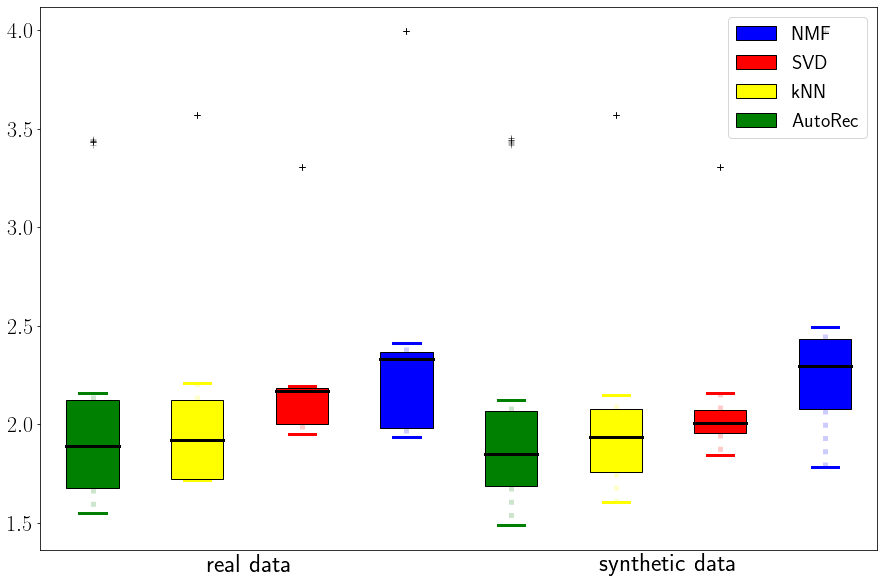

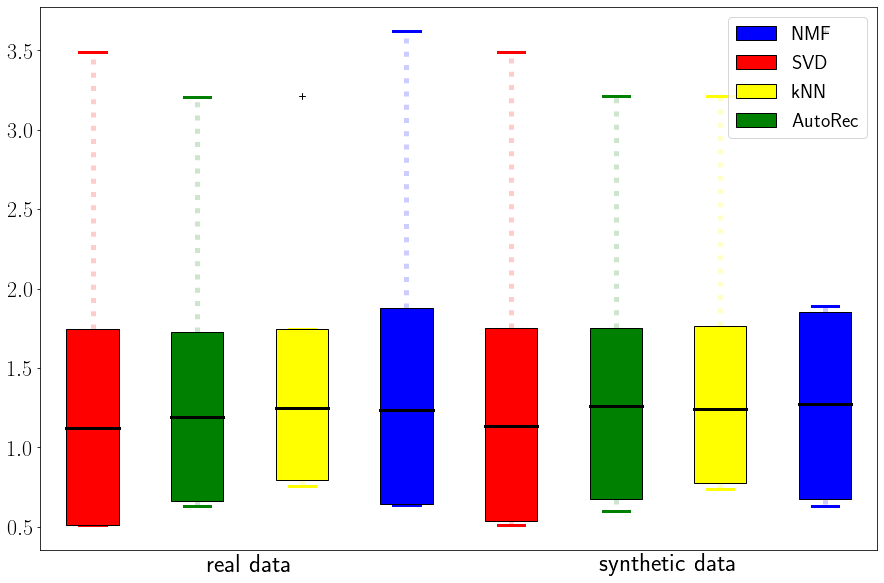

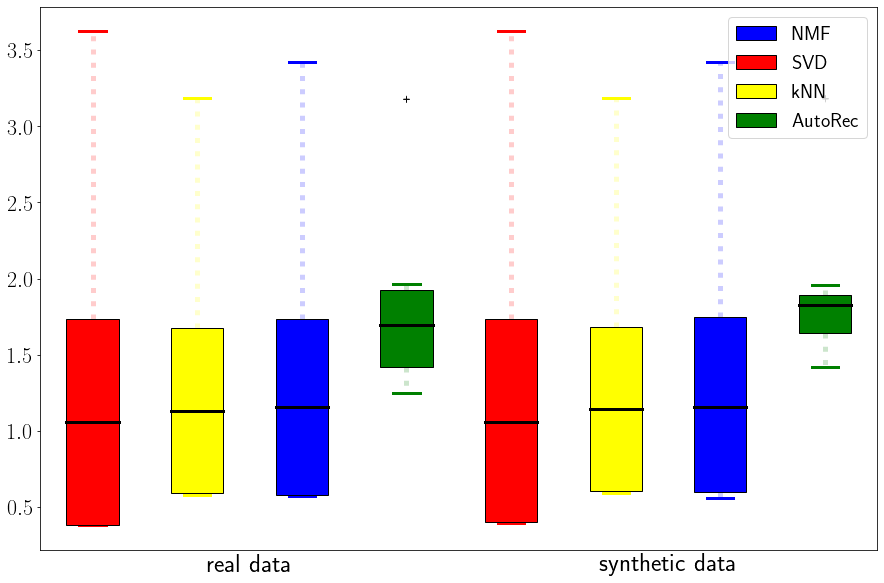

In [36]:
real = real_results
syn = syn_results

boxplot(real[real.sample_size==0.1], syn[syn.sample_size==0.1], legend_loc='upper right')

boxplot(real[real.sample_size==0.5], syn[syn.sample_size==0.5], legend_loc='upper right')

boxplot(real[real.sample_size==0.9], syn[syn.sample_size==0.9], legend_loc='upper right')

# Real-Syn Comparison (sparse case)

## Syn Data

In [6]:
syn_results = pd.DataFrame()
with torch.cuda.device(0):
    for num in np.arange(1, 11):
        syn_users_df = syn_users_generator.sample(SYNTHETIC_USERS_COUNT)
        syn_items_df = syn_items_generator.sample(SYNTHETIC_ITEMS_COUNT)


        syn_users_df["user_id"] = range(len(syn_users_df))
        syn_items_df["item_id"] = range(len(syn_items_df))

        syn_users_df["_merge_key"] = syn_items_df["_merge_key"] = 1
        syn_merged_df = pd.merge(syn_users_df, syn_items_df, on="_merge_key")
        syn_merged_df = syn_merged_df.drop(["_merge_key"], axis=1)

        syn_users_matrix = np.asarray(syn_merged_df.drop(['user_id', 'item_id'], axis = 1).iloc[:, 0:MATRIX_SIZE])
        syn_items_matrix = np.asarray(syn_merged_df.drop(['user_id', 'item_id'], axis = 1).iloc[:, MATRIX_SIZE:])


        df_resp = syn_merged_df.sample(frac=0.05)
        df_resp_no = syn_merged_df.drop(df_resp.index)

        npr.seed(SEED)
        resp = dt.predict(df_resp.drop(["user_id", "item_id"], axis=1))
        df_resp['rating'] = resp
        df_resp_no['rating'] = np.asarray([np.nan for i in range(df_resp_no.shape[0])])
        df_full = pd.concat([df_resp, df_resp_no])

        matrix = pd.DataFrame()
        matrix["rating"] = df_full['rating']
        matrix["user_id"] = df_full["user_id"].astype("category").cat.codes
        matrix["item_id"] = df_full["item_id"].astype("category").cat.codes

        mt = matrix.drop_duplicates(["user_id", "item_id"]).reset_index().drop("index", axis=1)
        mtp = mt.pivot(index="user_id", columns="item_id", values="rating")
        
        
        _resp_fn_config = evaluator.ResponseFunctionConfig(
        factory=ResponseFunction,
        args=[mtp, mtp, mtp]
        )
    
        _evaluators = [

            evaluator.TrainTestExecutorConfig(
                factory=trainers.NmfTrainTestExecutor,
                args={},
                model_name="nmf"
            ),
            evaluator.TrainTestExecutorConfig(
                factory=trainers.SvdTrainTestExecutor,
                args={},
                model_name="svd"
            ),
            evaluator.TrainTestExecutorConfig(
                factory=trainers.KnnTrainTestExecutor,
                args={},
                model_name="knn"
            ),
            evaluator.TrainTestExecutorConfig(
                factory=trainers.AutoRecTrainTestExecutor,
                args={},
                model_name="autorec"
            ) 
        ]

        np.random.seed(SEED)
        _evaluator = evaluator.Evaluator(_resp_fn_config, n_proc=4)

        

        results = _evaluator.evaluate(
            _evaluators, 
            a_sample_rate=2,
            test_size=0.2, 
            sample_sizes=[0.1, 0.3, 0.5, 0.9]
        )

        syn_results = syn_results.append(results)

Subprocess started.
Subprocess started.
Subprocess started.
RMSE: 2.2623
MAE:  1.9413
RMSE: 2.2623RMSE: 2.2623

MAE:  1.9413MAE:  1.9413

RMSE: 2.6637
MAE:  2.1608
RMSE: 2.6637RMSE: 2.6637

MAE:  2.1608MAE:  2.1608

RMSE: 2.6635
MAE:  2.1790
RMSE: 2.6635RMSE: 2.6635

MAE:  2.1790MAE:  2.1790

RMSE: 2.5721
MAE:  2.0731
RMSE: 2.5721RMSE: 2.5721

MAE:  2.0731MAE:  2.0731

RMSE: 2.7185RMSE: 2.7185

MAE:  2.0408MAE:  2.0408

RMSE: 2.3853RMSE: 2.3853

MAE:  2.0516MAE:  2.0516

RMSE: 2.9117RMSE: 2.9117
MAE:  2.3712

MAE:  2.3712
RMSE: 2.3942
MAE:  1.9170
RMSE: 2.3942
MAE:  1.9170
RMSE: 2.1862
MAE:  1.7432
RMSE: 2.6147
MAE:  2.0858
RMSE: 2.5045
MAE:  2.0494
RMSE: 2.5773
MAE:  2.1253
Subprocess started.
RMSE: 2.1812
MAE:  1.7890
RMSE: 2.0776
MAE:  1.7164
RMSE: 2.1993
MAE:  1.8201
Subprocess started.Subprocess started.

RMSE: 2.1812
RMSE: 2.1812MAE:  1.7890

MAE:  1.7890
RMSE: 2.0511
MAE:  1.7354
RMSE: 2.0776
MAE:  1.7164
RMSE: 2.1993
MAE:  1.8201
RMSE: 2.0776
MAE:  1.7164
RMSE: 2.0511
MAE:  1.7

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 13216576443706195237), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 3855619690625211166)]
IAutoRec.
[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 3133198882071874129), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14418338835004559077)]
IAutoRec.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


-----------------------Start 1-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 1-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 1-----------------------
-----------------------Start 5-----------------------
Sess
-----------------------Start 5-----------------------
Sess
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
Epoch: 0000; Epoch: 0000; RMSE:5.964302218863702; MAE:5.724131357183905
RMSE:5.951476982013729; MAE:5.703555639626684
Epoch: 0000; Epoch: 0003; RMSE:5.962959325538045; MAE:5.7

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 15036226980926098793), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 18367360750262021035)]


IAutoRec.[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 7780856018164351889), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1281300921730100718)]

IAutoRec.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.WARNING:tensorflow:From ./modules/models.py:111: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.WARNING:tensorflow:From ./modules/models.py:111: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3----------------------------------------------Start 5-----------------------

Sess
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
-----------------------Start 5-----------------------
Sess
Epoch: 0000; RMSE:5.291616266378459; MAE:4.999585284644963
Epoch: 0000; Epoch: 0000; RMSE:5.2811358655733365; MAE:4.990984334497007
RMSE:5.291041649691781; MAE:4.9900977942983

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 10958234529463053740), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 11445754305962894582)][_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 16398950584810003864), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 677911722248965655)]

IAutoRec.IAutoRec.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.WARNING:tensorflow:From /data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Instructions for updating:
If using Keras pass *_constraint arguments to layers.WARNING:tensorflow:From /data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.WARNING:tensorflow:From ./modules/models.py:111: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


-----------------------Start 1-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
Epoch: 0000; RMSE:5.65766581860992; MAE:5.32074917636648
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 2----------------------------------------------Start 4-----------------------

-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
Epoch: 0003; -----------------------Start 5-----------------------
Sess
RMSE:5.2881456441534205; MAE:4.955757747427358
Epoch: 0006; RMSE:5.055193280292945; MAE:4.66358977389036


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 7428183407882711702), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8552242743099312722)]
IAutoRec.
[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 170352358380714056), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8505241760290811342)]WARNING:tensorflow:From /data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

IAutoRec.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 2----------------------------------------------Start 1-----------------------

-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
-----------------------Start 5-----------------------
Sess
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
Epoch: 0000; RMSE:5.29996109214941; MAE:4.835675072202685
Epoch: 0000; RMSE:5.28770713711725; MAE:4.814354645440581
Epoch: 0003; RMSE:4.951284419116267; MAE:4.438417818085088


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 7021866091387582482), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 10102102900855125030)]
IAutoRec.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 13503605166721630902), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 10420421440807949032)]
IAutoRec.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.WARNING:tensorflow:From /data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.WARNING:tensorflow:From /data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


-----------------------Start 1-----------------------
-----------------------Start 2----------------------------------------------Start 1-----------------------

-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 1-----------------------
-----------------------Start 5-----------------------
Sess
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3----------------------------------------------Start 5-----------------------

Sess
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
Epoch: 0000; RMSE:5.210877354539172; MAE:4.803680096732678
Epoch: 0000; RMSE:5.2134191092651; MAE:4.804950085411074
Epoch: 0000; Epoch: 0003; RMSE:5.185794592654769; MAE:4.785

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 16288507900310412628), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 6540379426365499263)][_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 3081927586495240070), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 10760394420100721303)]
IAutoRec.

IAutoRec.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.WARNING:tensorflow:From /data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.WARNING:tensorflow:From ./modules/models.py:111: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.WARNING:tensorflow:From ./modules/models.py:111: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



-----------------------Start 1-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
Epoch: 0000; -----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
RMSE:5.5109170484295875; MAE:5.12293264737189
-----------------------Start 5-----------------------
Sess
Epoch: 0003; Epoch: 0000; RMSE:5.134190745042062; MAE:4.6879783988168855
RMSE:5.520607299785058; MAE:5.1289806920646

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 5181990895899267424), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 9020760637171886119)]
[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 11465217071409705215), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 18233214453220729375)]IAutoRec.

IAutoRec.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


-----------------------Start 1-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
-----------------------Start 2-----------------------Epoch: 0000; -----------------------Start 2-----------------------

-----------------------Start 3----------------------------------------------Start 3-----------------------

-----------------------Start 4----------------------------------------------Start 4-----------------------

RMSE:5.456695148918827; MAE:5.0475933463668845
-----------------------Start 5-----------------------
Sess-----------------------Start 5-----------------------

Sess
Epoch: 0003; RMSE:5.108342318677773; MAE:4.660726688452794
Epoch: 0000; Epoch: 0000; Epoch: 0006; RMSE:4.9207303031

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 7017468836120102208), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 11926320355141898968)]
IAutoRec.
[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 7661570320942939048), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 657188312211279526)]
IAutoRec.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 1-----------------------
-----------------------Start 5-----------------------
Sess
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
-----------------------Start 5-----------------------
Sess
Epoch: 0000; RMSE:5.2927227387423725; MAE:4.992782145848723
Epoch: 0000; Epoch: 0000; RMSE:5.313395913375239; MAE:5.013986961541923
RMSE:5.327426277632034; MAE:5.0133492996713

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
-----------------------Start 5-----------------------
Sess
Epoch: 0000; RMSE:4.677811274764456; MAE:4.326600649392458
Epoch: 0000; -----------------------Start 1-----------------------
Epoch: 0003; RMSE:4.3112443385404635; MAE:3.9296706922210594
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------RMSE:4.660948150677033; MAE:4.300237080360057
Epoch: 0006; 
RMSE:4.0626707588494915; MAE:3.64083902698

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 7585813057514042437), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 2631730225379001290)]
IAutoRec.
[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 37075523466714771), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 9574912993464050253)]
IAutoRec.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


-----------------------Start 1-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 1-----------------------
-----------------------Start 5-----------------------
Sess
-----------------------Start 1-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 2----------------------------------------------Start 5-----------------------

-----------------------Start 3-----------------------Sess

-----------------------Start 4-----------------------
Epoch: 0000; RMSE:5.105362428993186; MAE:4.680487835312488
-----------------------Start 5-----------------------
Sess
Epoch: 0000; Epoch: 0003; RMSE:5.099949894813624; MAE:4.695615626143518
RMSE:4.672231352551765; MAE:4.23364257776946

## Real Data

In [17]:
import torch
real_results = pd.DataFrame()

for num in range(10):
    
    df_resp = df_merge.sample(frac=0.05)
    df_resp_no = df_merge.drop(df_resp.index)
    df_resp_no.rating = np.nan
    df_full = pd.concat([df_resp, df_resp_no])

    matrix = pd.DataFrame()
    matrix["rating"] = df_full['rating']
    matrix["user_id"] = df_full["user_id"].astype("category").cat.codes
    matrix["item_id"] = df_full["item_id"].astype("category").cat.codes

    mt = matrix.drop_duplicates(["user_id", "item_id"]).reset_index().drop("index", axis=1)
    mtp = mt.pivot(index="user_id", columns="item_id", values="rating")
        
    _resp_fn_config = evaluator.ResponseFunctionConfig(
    factory=ResponseFunction,
    args=[mtp, mtp, mtp]
    )
    
    _evaluators = [
    
    evaluator.TrainTestExecutorConfig(
        factory=trainers.NmfTrainTestExecutor,
        args={},
        model_name="nmf"
    ),
    evaluator.TrainTestExecutorConfig(
        factory=trainers.SvdTrainTestExecutor,
        args={},
        model_name="svd"
    ),
    evaluator.TrainTestExecutorConfig(
        factory=trainers.KnnTrainTestExecutor,
        args={},
        model_name="knn"
    ),
    evaluator.TrainTestExecutorConfig(
        factory=trainers.AutoRecTrainTestExecutor,
        args={},
        model_name="autorec"
    ) 
    ]
    
    np.random.seed(SEED)
    _evaluator = evaluator.Evaluator(_resp_fn_config, n_proc=4)
    
    with torch.cuda.device(1):
        results = _evaluator.evaluate(
            _evaluators, 
            a_sample_rate=2,
            test_size=0.2, 
            sample_sizes=[0.1, 0.3, 0.5, 0.9]
        )

    
    real_results = real_results.append(results)

Subprocess started.
Subprocess started.
Subprocess started.
RMSE: 2.7772
MAE:  2.2401
RMSE: 2.7772
MAE:  2.2401
RMSE: 2.7772
MAE:  2.2401
RMSE: 3.0823
MAE:  2.4911
RMSE: 3.0823
RMSE: 3.0823
MAE:  2.4911
MAE:  2.4911
RMSE: 2.8999
MAE:  2.3265
RMSE: 2.8999
MAE:  2.3265
RMSE: 2.8999
MAE:  2.3265
RMSE: 2.7008
MAE:  2.1128
RMSE: 2.7008
MAE:  2.1128
RMSE: 2.7008
MAE:  2.1128
RMSE: 2.7268
MAE:  2.3975
RMSE: 2.7268
MAE:  2.3975
RMSE: 2.7677
MAE:  2.1633
RMSE: 2.7677
MAE:  2.1633
RMSE: 2.8909
MAE:  2.3290
RMSE: 2.8909
MAE:  2.3290
RMSE: 2.5814
MAE:  2.0001
RMSE: 2.5814
MAE:  2.0001
RMSE: 2.9941
MAE:  2.5269
RMSE: 2.8058
MAE:  2.2987
RMSE: 2.9546
MAE:  2.3600
RMSE: 2.6478
MAE:  2.0779
Subprocess started.
RMSE: 2.6219
MAE:  2.2185
Subprocess started.
Subprocess started.
RMSE: 2.6219
MAE:  2.2185
RMSE: 2.3260
MAE:  1.9659
RMSE: 2.6219
MAE:  2.2185
RMSE: 2.3260
MAE:  1.9659
RMSE: 2.3260
MAE:  1.9659
RMSE: 2.3656
MAE:  1.9863
RMSE: 2.3656
MAE:  1.9863
RMSE: 2.3656
MAE:  1.9863
RMSE: 2.2533
MAE:  1.8

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 1958225027277001631), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8713302358820851701)]
IAutoRec.
[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 13671887223297729572), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 9193034274649475118)]
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
Epoch: 0000; -----------------------Start 5-----------------------
Sess
RMSE:5.248649016010091; MAE:4.647886751373976
-----------------------Start 5-----------------------
Sess
Epoch: 0000; RMSE:5.2623011310021495; MAE:4.65919286935658
Epoch: 0000; RMSE:5.235709223751618; MAE:4.63553109797251

Instructions for updating:
If using Keras pass *_constraint arguments to layers.WARNING:tensorflow:From /data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.WARNING:tensorflow:From ./modules/models.py:111: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.WARNING:tensorflow:From ./modules/models.py:111: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 17082360303782304441), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14945567252530067836)]
IAutoRec.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


-----------------------Start 1----------------------------------------------Start 1-----------------------

-----------------------Start 1-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4----------------------------------------------Start 2-----------------------

-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess-----------------------Start 5-----------------------

Sess
-----------------------Start 5-----------------------
Sess
Epoch: 0000; RMSE:5.630458880226119; MAE:5.0020382938230075
Epoch: 0000; Epoch: 0000; RMSE:5.640167554778749; MAE:5.015252341921315
RMSE:5.636331687838864; MAE:5.0186254039638

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 4407438660767031549), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 13182522455960462245)][_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 12575809541393794627), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8391996793595946090)]


IAutoRec.IAutoRec.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.WARNING:tensorflow:From /data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Instructions for updating:
If using Keras pass *_constraint arguments to layers.WARNING:tensorflow:From /data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.WARNING:tensorflow:From ./modules/models.py:111: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.WARNING:tensorflow:From ./modules/models.py:111: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



-----------------------Start 1-----------------------
-----------------------Start 1----------------------------------------------Start 1-----------------------

-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 2-----------------------
-----------------------Start 4----------------------------------------------Start 3-----------------------

-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
-----------------------Start 5-----------------------
-----------------------Start 5-----------------------Sess

Sess
Epoch: 0000; Epoch: 0000; Epoch: 0000; RMSE:5.642278061413048; MAE:5.0176740042258645
RMSE:5.6419527236683775; MAE:5.022718810282987
RMSE:5.635289418698316; MAE:5.007744070230

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 7505372423016700634), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 17278231185794607869)]
IAutoRec.
[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 17642523398979934177), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 3523800311589550628)]
IAutoRec.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
-----------------------Start 2----------------------------------------------Start 2-----------------------

-----------------------Start 3----------------------------------------------Start 3-----------------------

-----------------------Start 4----------------------------------------------Start 4-----------------------

-----------------------Start 5----------------------------------------------Start 5-----------------------

SessSess

Epoch: 0000; RMSE:5.653676161289937; MAE:5.030282398916189
Epoch: 0000; RMSE:5.649339336072266; MAE:5.0275361406918275
Epoch: 0000; RMSE:5.652882626415514; MAE:5.0302198105176

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 3025522236199763055), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 5343960294165650940)]
IAutoRec.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 14643770037082881348), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 6551840806087967010)]
IAutoRec.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
-----------------------Start 5-----------------------
Sess
Epoch: 0000; RMSE:5.647392034169187; MAE:5.026965524731077
Epoch: 0000; RMSE:5.641939348397905; MAE:5.020320359154012
Epoch: 0000; RMSE:5.63758265466893; MAE:5.015945365601093

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 3959356614313902316), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 13007196586491738408)]
IAutoRec.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess-----------------------Start 2-----------------------

-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
-----------------------Start 5-----------------------
Sess
Epoch: 0000; RMSE:5.631604609908421; MAE:5.012668658201456
Epoch: 0000; Epoch: 0000; RMSE:5.644311399118214; MAE:5.024888440115483
RMSE:5.6378577169703155; MAE:5.0170405295909

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 4135818933343585950), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 15195079869729985502)]
IAutoRec.
[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 6521893270061504516), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 18422626960625559674)]
IAutoRec.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
-----------------------Start 5-----------------------
Sess
Epoch: 0000; RMSE:5.645362638369502; MAE:5.025451428263787
Epoch: 0000; Epoch: 0000; RMSE:5.643825681373655; MAE:5.026041076101702
RMSE:5.640735178860926; MAE:5.01151054545991

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 8269032241515715838), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16371804392176834279)]
IAutoRec.[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 178384819726035300), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 13847353890021988344)]

IAutoRec.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
-----------------------Start 2-----------------------
-----------------------Start 2----------------------------------------------Start 3-----------------------

-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
-----------------------Start 5-----------------------Sess

Sess
Epoch: 0000; RMSE:5.662664327498936; MAE:5.03825354315095
Epoch: 0000; RMSE:5.6462260264382325; MAE:5.026611759583339
Epoch: 0000; RMSE:5.649736431460494; MAE:5.02512417360661

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 2316348772869046050), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 12977081164660899271)]
IAutoRec.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 4530331669172408881), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1042927596482704320)]
IAutoRec.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 1-----------------------
-----------------------Start 5-----------------------
Sess
Epoch: 0000; -----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
RMSE:5.636912128631763; MAE:5.016875165095426
-----------------------Start 5-----------------------
Sess
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
Epoch: 0003; RMSE:5.273871412318039; MAE:4.562789252835715
-----------------------Start 5-----------------------
Sess
Epoch: 0000; RMSE:5.634380647112695; MAE:5.01490003289176

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 8781022914192039272), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 15204999454371370638)][_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 816642759497583101), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 11891591931659693398)]

IAutoRec.IAutoRec.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.WARNING:tensorflow:From /data/home/agurov/.conda/envs/py3.6/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.WARNING:tensorflow:From ./modules/models.py:111: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.WARNING:tensorflow:From ./modules/models.py:111: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
-----------------------Start 1-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 2-----------------------
-----------------------Start 3-----------------------
-----------------------Start 4-----------------------
-----------------------Start 5-----------------------
Sess
-----------------------Start 5-----------------------
Sess
Epoch: 0000; Epoch: 0000; RMSE:5.636151282460298; MAE:5.019950383375272
RMSE:5.642781369302882; MAE:5.0246384889584625
Epoch: 0000; RMSE:5.651926113913194; MAE:5.0191202985028

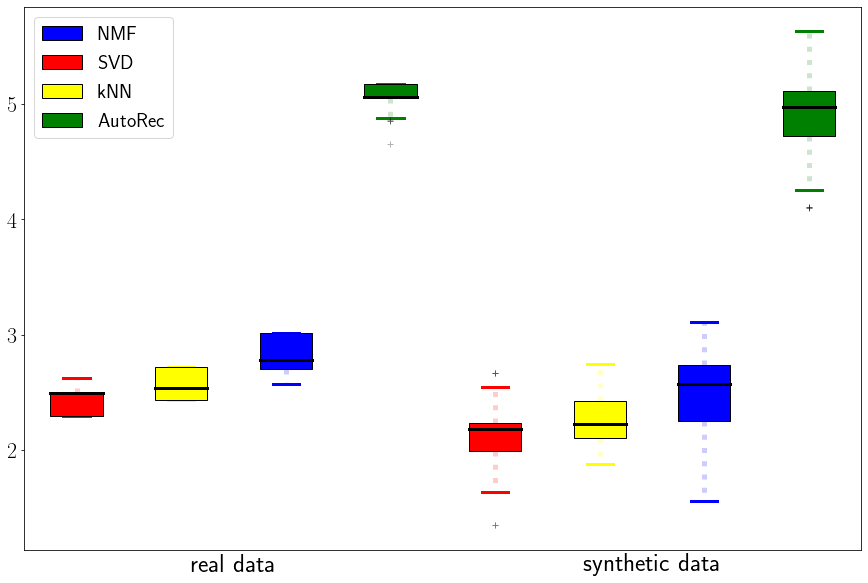

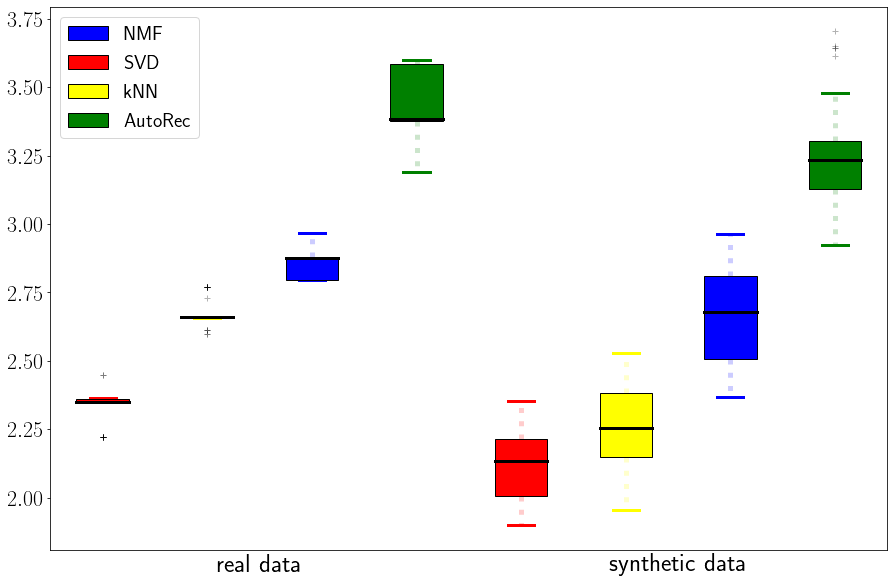

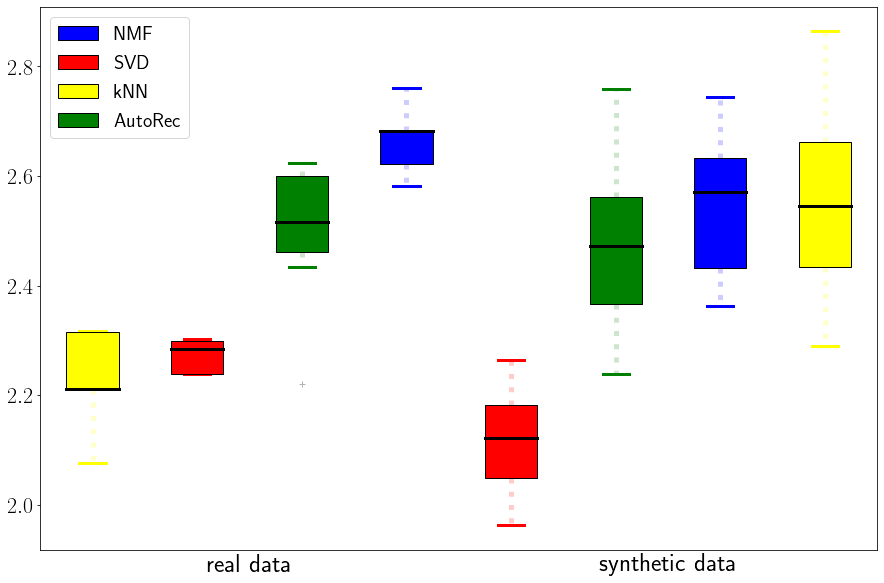

In [35]:
real_sparce = real_results
syn_sparce = syn_results

boxplot(real_sparce[real_sparce.sample_size==0.1], syn_sparce[syn_sparce.sample_size==0.1], legend_loc='upper left')

boxplot(real_sparce[real_sparce.sample_size==0.5], syn_sparce[syn_sparce.sample_size==0.5], legend_loc='upper left')

boxplot(real_sparce[real_sparce.sample_size==0.9], syn_sparce[syn_sparce.sample_size==0.9], legend_loc='upper left')